In [1]:
import gymnasium
import numpy as np
import random
import matplotlib.pyplot as plt
import imageio

In [2]:
env = gymnasium.make('MountainCar-v0', max_episode_steps=1000, render_mode="rgb_array")

In [3]:
# selecting a uniform discretization step (∆)
def get_bins(n_discrete_steps):
    position_bins = np.linspace(env.observation_space.low[0], env.observation_space.high[0], n_discrete_steps)
    velocity_bins = np.linspace(env.observation_space.low[1], env.observation_space.high[1], n_discrete_steps)
    return position_bins, velocity_bins

In [4]:
# preprocess continuous states into discrete states
def discretize_state(state, position_space, velocity_space):
    position_idx = np.digitize(state[0], position_space) - 1
    velocity_idx = np.digitize(state[1], velocity_space) - 1
    return position_idx, velocity_idx

In [5]:
def random_argmax(arr):
    max_value = np.max(arr)
    max_indices = np.where(arr == max_value)[0]
    random_index = random.choice(max_indices)
    return random_index

In [6]:
def eps_greedy_policy(Q, epsilon, action_space):
    # define an epsilon-greedy policy function based on Q table
    def policy_func(state):
        # initialize a uniform distribution for all actions with a bias of epsilon
        prob_distribution = np.ones(action_space) * epsilon / action_space
        # use random_argmax to choose action with the highest Q value (with ties broken arbitrarily)
        best_action = random_argmax(Q[state])
        # increase probability of taking the best action by 1 - epsilon
        prob_distribution[best_action] += (1 - epsilon)
        return prob_distribution

    return policy_func

In [7]:
def q_learning(env, n_discrete_steps, num_episodes=1000, epsilon=0.3, gamma=1, alpha=0.1, render=False):
    position_bins, velocity_bins = get_bins(n_discrete_steps)

    Q = np.zeros((n_discrete_steps, n_discrete_steps, env.action_space.n))

    rewards = []

    for episode in range(1, num_episodes + 1):
        if episode % 100 == 0:
            print(f"\r∆ = {n_discrete_steps}: Episode {episode}/{num_episodes}.", end="")

        state = discretize_state(env.reset()[0], position_bins, velocity_bins)
        episode_rewards = 0

        frames = []

        while True:
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, done, _, _ = env.step(action)
            next_state_discrete = discretize_state(next_state, position_bins, velocity_bins)

            if render and episode == num_episodes:
                frame = env.render()
                frames.append(frame)

            td_target = reward + gamma * np.max(Q[next_state_discrete])
            Q[state + (action,)] += alpha * (td_target - Q[state + (action,)])
            
            episode_rewards += reward
            if done:
                rewards.append(episode_rewards)
                break  # exit loop if agent has reached target
            
            state = next_state_discrete

        if render and episode == num_episodes:
            imageio.mimsave(f'{n_discrete_steps}s.gif', frames, fps=40)

    return rewards

In [8]:
cumulative_rewards = {d_steps: q_learning(env, d_steps) for d_steps in [3, 5, 8, 15, 20, 25]}

∆ = 25: Episode 1000/1000.

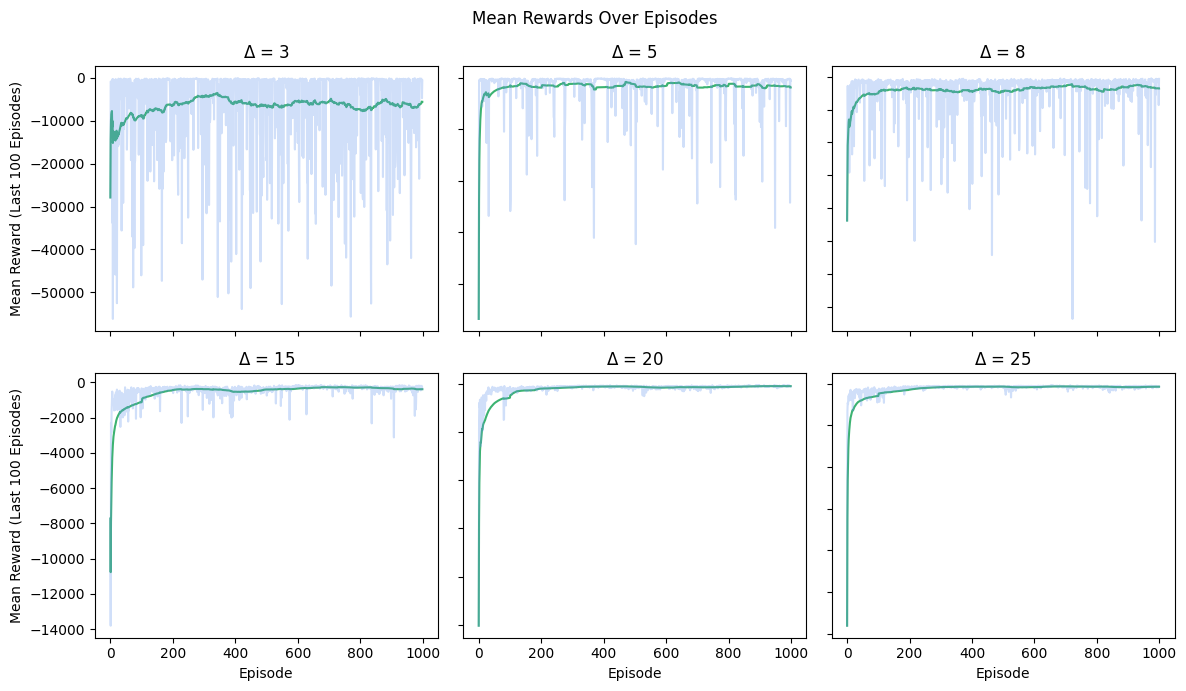

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
fig.suptitle('Mean Rewards Over Episodes')

for i, (n_discrete_steps, rewards) in enumerate(cumulative_rewards.items()):
    ax = axes[i // 3, i % 3]
    mean_rewards = [np.mean(rewards[max(0, i - 100):i + 1]) for i in range(len(rewards))]

    ax.plot(mean_rewards, color="mediumseagreen")
    ax.plot(rewards, color="cornflowerblue", alpha=0.3)
    ax.set_title(f'$\Delta$ = {n_discrete_steps}')

for ax in axes.flat:
    ax.set(xlabel='Episode', ylabel='Mean Reward (Last 100 Episodes)')
    ax.label_outer()

plt.tight_layout()
plt.show()